In [1]:
!pip install googletrans
!pip install konlpy

In [2]:
%matplotlib inline

from sklearn import svm
from keras.utils import get_file
import os
import gensim
import subprocess
import numpy as np
import random
import requests
import pandas as pd
from IPython.core.pylabtools import figsize
import csv
import matplotlib.pyplot as plt
import tqdm.notebook as tq

In [3]:

# 주의 사항 
# 한글 설치. 설치 후 [ ctrl + M + . ] 으로 런타임 다시 시작해야 함. 
 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
 
# 폰트 다운 받기
!apt -qq -y install fonts-nanum
 
# 폰트 설정하기 
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=path, size=10)
plt.rc('font', family='NanumBarunGothic') 
matplotlib.font_manager._rebuild()

'apt'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [4]:
from googletrans import Translator
translator = Translator()
trans = translator.translate(['폭력',"짜증"], dest="en")
for i in trans:
    print(i.origin, i.text)

폭력 violence
짜증 petulance


In [5]:
import gensim.downloader as api

model = api.load('glove-wiki-gigaword-300')
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
stwd = stopwords.words('english')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\beomj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
naver = pd.read_excel("naver_리뷰정제후.xlsx")
imdb  = pd.read_excel("imdb_리뷰정체후.xlsx")
movie = pd.read_excel("1970_2020_raw영화데이터_kobiz_update.xlsx")
ko_stopwords = list(pd.read_excel("ko_stopwords.xlsx").T.values[0])
en_stopwords = list(pd.read_excel("en_stopwords.xlsx").T.values[0])
movie.genre = movie.genres.apply(lambda x: str(x).split(',')[0].strip() if x else '없음')
#imdb.columns = [i+'en' for i in imdb.columns]

C:\Users\beomj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [ ]:
""" 영어, 한국어 전처리 다시할 필요 없음
from tqdm.auto import tqdm
from nltk.stem.wordnet import WordNetLemmatizer
import re

nltk.download('wordnet')
# English Preprocessing ----------------------------------------------------------------
print("Start English Preprocessing...")
def trim_en(text):
    text = str(text)
    #text =text.lower()
    text=re.sub("[(<.*?>)'']"," ",text)
    text=re.sub("(\\W|\\d)"," ",text)
    text=text.strip()
    
    return text

lemm =  WordNetLemmatizer()

tqdm.pandas(position=0, leave=True)
imdb.리뷰en = imdb.리뷰en.progress_apply(trim_en)
imdb.리뷰en = imdb.리뷰en.progress_apply(lambda s:" ".join([lemm.lemmatize(w) for w in str(s).split()]) )

from konlpy.tag import Okt, Kkma

print("Start Korean Preprocessing")
okt = Okt()
kkma = Kkma()
def trim_ko(x):
    text=re.sub("[(<.*?>)/'…“”']"," ",x)
    text = " ".join([w[0] for w in okt.pos(text) if (w[0] not in ko_stopwords) and (w[1]=="Noun" or w[1]=='Verb' or w[1]=="Adjective")])
    text=text.strip()
    return text

naver.리뷰.fillna("", inplace=True)
naver.리뷰 =naver.리뷰.astype(str)

naver.리뷰 = naver.리뷰.apply(lambda x:x.replace("\n"," "))
naver.리뷰 = naver.리뷰.progress_apply(trim_ko)
"""

In [10]:
df = naver.join(imdb)
print(df.columns)
df = df[(df['리뷰'].notnull()) & (df['리뷰en'].notnull())]
df = df[(df.리뷰.apply(lambda x:True if len(str(x))>5 else False)) & (df.리뷰en.apply(lambda x:True if len(str(x))>5 else False))]
df = df.join(movie.genre)
df.head()

Index(['영화명', '스토리', '평점', '리뷰', '영화명ENen', '리뷰en', '평점en', '시청등급en'], dtype='object')


,영화명,스토리,평점,리뷰,영화명ENen,리뷰en,평점en,시청등급en,genres
2,드라이브,"줄거리\n차가운 심장의 남자,\n지켜야 할 사람이 생겼다!\n삶의 의미라곤 오직 스...",8.04,매우 폭력 스타일리시 매력 저절로 웃음 기존 액션 영화 예술 미와 아름다 움 라이언...,Drive,One reviewer here suggested that instead of se...,NaN,NaN,액션
8,킬러맨,줄거리\n뉴욕의 돈세탁 업자 ‘모’는 파트너 ‘스컹크’와 함께\n 마약 거래에 뛰어...,5.40,걸 끝 본 사람 나중 대성 할 겁니다 전 실패했거든요 인생 최악 영화 평점 점 보고...,Killerman,Strong performance intimidating villain claust...,"5.4/10\n3,165",18,액션
9,테넷,줄거리\n당신에게 줄 건 한 단어 ‘테넷’\n“이해하지 말고 느껴라!”\n시간의 흐...,8.65,이영화 보고 나올 드는 생각 한번 봐야겠다 추강 추강 요어밌재 말정 도래 만지겠 르...,Tenet,First viewing I couldn t understand the dialog...,"8.4/10\n2,577",12,액션
10,존 윅 - 리로드,줄거리\n장전 완료! 준비는 끝났다!\n업계 최고의 레전드 킬러 ‘존 윅’은 과거를...,8.05,피어스 네오 다시 만나다니 감동 연필 무서움 편 존 윅 부기맨 명 연필 하나로 죽였...,John Wick Chapter Two,Adding to his earlier Wickipedia page with a s...,"7.5/10\n351,231",18,액션
12,O.J. 심슨 사건 파일,"줄거리\n미 전역을 들끓게 한 충격 실화\nO.J. 심슨, 아내 살해 혐의로 체포되...",8.50,실제 살인 범 심슨 임 영화 일반 연쇄 살인 범 니콜 브라운 심슨 살해 묘사 되네요...,The Murder of Nicole Brown Simpson,Completely fictional trash Bad acting Bad dire...,2.1/10\n868,18,스릴러


In [26]:
from tqdm.auto import tqdm

#words = ["슬픔", "재미","즐거움","걱정","공포","놀라움"]
words = ["스토리", "연기","배우","감독","음악"]
#words = ['저녁', "코딩", "프로젝트", "열심히", "야호"]
n = 100

translator = Translator()
trans = translator.translate(words, dest="en")
lst = [model.most_similar(positive=[word.text.lower()],topn=n) for word in trans ]
lst = [[j[0] for j in i  if j[0] not in stwd] for i in lst]

lst = [[words[k]] + [j.text for j in translator.translate(i, dest="ko")]  for k,i in tqdm(enumerate(lst))]

In [27]:

lst2 = [model.most_similar(positive=[word.text.lower()],topn=n) for word in trans  ]
lst2 = [ [trans[k].text] + [j[0] for j in i]  for k,i in tqdm(enumerate(lst2))]


In [28]:
lst = [[[k for k in i.split() if k not in  ko_stopwords]  for i in j] for j in lst]
lst2 = [[i for i in j if not (i in stwd) and (i not in en_stopwords)] for j in lst2]
lst = [[i[0] for i in j if i] for j in lst]

for j in range(len(lst)):
    print(lst[j][0], ": ", end="")
    for i in range(1, len(lst[j])):
        print(lst[j][i], end=" ")
    print()

for j in range(len(lst2)):
    print(lst2[j][0], ": ", end="")
    for i in range(1, len(lst2[j])):
        print(lst2[j][i], end=" ")
    print()

스토리 : 이야기 소설 책 이야기 영화 캐릭터 문자 특색 주역 소설 생명 사랑 필름 말함 짧은 작가 삽화 드라마 공상 쓴 꾸며낸 신비 흥미로운 설명 진실 모험 : 로맨스 기록한 조각 삽화 회상록 내레이터 전제 음모 썼다 영감 설명 실물 그림 남자 장면 만화 뉴스 테마 저자 장면 줄거리 시나리오 전기 해설 끝 테마 설득력있는 회전하다 페이지 적응 온다 풍모 간다 전개 모험 소녀 계시하다 사거 로맨틱 조 스크립트 나타납니다 매혹적인 일어난 . 꿈 설명 시 진실 여행 아무것도 사실은 
연기 : 행동 역할 연출 역할 정해진 대리인 배우 조수 감독 지명 배우 약속 취득 행위 동무 실행할 감독 책임 추정 지원 직장 행위 극장 재능 사무실 봉사 추구하다 권위 일했다 관리 대신 명음 방향 관리자 사임 뒤얽힌 지도 떠나다 드라마 비서 재능 주어진 행정부 가르치는 임명 극장 감독 주요한 연극 유효한 동작 대리인 위원 대사 공연 위치 공연 상관 선생님 간청자 학과 어울리는 학원 코메디 잘 했다 직업 주요한 극단 정하다 머리 성공하다 코미디 뮤지컬 사무 공부 성공 놀이 은퇴 취하다 정부 관리 말하기 강사 수행자 물었다 영화 단계 특별한 
배우 : 여배우 주연 배우 코미디언 별표 시나리오 영화 필름 음악가 코메디 영화 수행자 가수 캐릭터 드라마 역할 극작가 연예인 별 별 오스카 영화 묘사 작곡가 시나리오 캐스트 여배우 할리우드 초상 연극 역할 작곡가 예술가 작가 춤추는 영화 베스트 지명 클루니 소설가 에미 공동 코미디 생산자 스턴트맨 촬영 아버지 연기 감독 피아니스트 재향 만화 볼리우드 크로우 지원 증여자 남편 동료 카메오 장학금 찬사 캐리 공동 공동 화면 손님 우주 태어난 묘사 행크스 연주 나란히 Eastwood 브란도 수상 가슴 스트립 코너리 악당 연출 텔레비전 뎁 친구 기업가 남자 젊은 묘사 게레 시트콤 뮤지컬 TV 각본 극작가 코미디언 니로 미니 파치노 무어 
감독 : 행정부 관리 조수 감독 감독 동무 매니저 대리인 머리 주요한 학회 말했다 필름 조정자 컨설턴트 바이스 교수 

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sa = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\beomj\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
ko_sent_dict = pd.read_csv('SentiWord_Dict.txt', sep="\t").set_index("단어")
ko_sent_dict

def score_ko(x):
    try:
        if x in ko_sent_dict.index:
            x = ko_sent_dict.loc[x, '감정']
        else:
            x = 0
    except:
        pass
    return x



score_ko("갈등")

score_ko("efe")
sa.polarity_scores("I'm tired")

{'neg': 0.744, 'neu': 0.256, 'pos': 0.0, 'compound': -0.4404}

In [31]:
indexes = df.index

values = []
values_pos = []
values_neg = []
names = []

values_e = []
values_e_pos = []
values_e_neg = []
names_e = []

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sa = SentimentIntensityAnalyzer()

print("Korean Sentiment Started .... ")
for i in tq.tqdm(indexes):
    review1 = naver.loc[i, '리뷰']
    movie_nm = naver.loc[i,'영화명']
    value = [0.001 for i in range(len(lst))]
    value_pos = [0.001 for i in range(len(lst))]
    value_neg = [0.001 for i in range(len(lst))]
    string_split = str(review1).split()
    for k2, i in enumerate(string_split):
        for k,j in enumerate(lst):
            if i in j:
                value[k] +=1
                left = max([0, k2-1])
                right = k2+4
                score =sum([score_ko(i) for i in string_split[left:right]])
                if score >2:
                    value_pos[k] += score
                if score <-3:
                    value_neg[k] += score

    names.append(movie_nm)

    #value_pos = [-value_pos[i]/value_neg[i] for i in range(len(value_pos))]
    SUM = sum(value_pos)
    v = [value_pos[i]/SUM for i in range(len(value_pos))]
    values_pos.append(v)

    #value_neg =  [-value_neg[i]/value_pos[i] for i in range(len(value_neg))]
    SUM = sum(value_neg)
    v = [value_neg[i]/SUM for i in range(len(value_neg))]
    values_neg.append(v)

    SUM = sum(value)
    value = [i/SUM for i in value]
    values.append(value)


print("English Sentiment Started .... ")
for i in tq.tqdm(indexes):
    review1 = imdb.loc[i, '리뷰en']
    movie_nm = imdb.loc[i,'영화명ENen']
    value = [0.001 for i in range(len(lst2))]
    value_pos = [0.001 for i in range(len(lst2))]
    value_neg = [0.001 for i in range(len(lst2))]
    string_split = str(review1).split()
    for k2, i in enumerate(string_split):
        for k,j in enumerate(lst2):
            if i in j:
                value[k] +=1
                left = max([0, k2-1])
                right = k2+4
                window = " ".join(string_split[left:right])
                scores = sa.polarity_scores(window)
                if scores['compound']>0.8:
                    value_pos[k] += scores['pos']
                if scores['compound']<-0.5:
                    value_neg[k] += scores['neg']

    names_e.append(movie_nm)
    
    #value_pos = [value_pos[i]/value[i] for i in range(len(value_pos))]
    SUM = sum(value_pos)
    v = [value_pos[i]/SUM for i in range(len(value_pos))]
    values_e_pos.append(v)

    #value_neg =  [value_neg[i]/value[i] for i in range(len(value_neg))]
    SUM = sum(value_neg)
    v = [value_neg[i]/SUM for i in range(len(value_neg))]
    values_e_neg.append(v)

    SUM = sum(value)
    value = [i/SUM for i in value]
    values_e.append(value)

Korean Sentiment Started .... 


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\beomj\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



English Sentiment Started .... 


In [32]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)




labels= words
markers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8 , 1]
str_markers = [str(i) for i in range(len(words))]

def make_radar_chart(names, statss, attribute_labels = labels, plot_markers = markers, plot_str_markers = str_markers):
    for i in range(len(names)):
        name = names[i]
        stats = statss[i]
        fig= plt.figure(figsize=(5,5))
        labels = np.array(attribute_labels)
        print(name)
        angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
        stats = np.concatenate((stats,[stats[0]]))
        angles = np.concatenate((angles,[angles[0]]))

        ax = fig.add_subplot(111, polar=True)
        ax.plot(angles, stats, 'o-', linewidth=2)
        ax.fill(angles, stats, alpha=0.25)

        ax.set_thetagrids(angles * 180/np.pi, labels)
        print(stats)
        step = (max(stats) - min(stats))//5
        markers =[0]+[ min(stats) + i*step for i in range(5) ]
        plt.yticks(markers)
        ax.set_title(name)
        ax.grid(True)

        #fig.savefig("static/images/%s.png" % name)

    return plt.show()
colors =  ['#da2a63', '#ff7f0e', '#2ca02c', '#da2acc', '#2467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#4f72b1', '#f3710e', '#4c301c', '#262728', '#4267bd', '#12544b', '#e321c2', '#123f7f', '#68bd22', '#572e5f']
def make_radar_charts(names, statss, title="", attribute_labels = labels, plot_markers = markers, fonts=10, plot_str_markers = str_markers):
        MAX = max([max(x) for x in statss])
        plot_markers = [i for i in plot_markers if i<=MAX+0.1]
        fig= plt.figure(figsize=(5,5))
        labels = np.array(attribute_labels)
        angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
        angles = np.concatenate((angles,[angles[0]]))
        ax = fig.add_subplot(111, polar=True)
        for i in range(len(names)):
            name = names[i]
            stats = statss[i]
            stats = np.concatenate((stats,[stats[0]]))
    
            ax.plot(angles, stats, 'o-', linewidth=2, alpha=0.5, color = colors[i])
            ax.fill(angles, stats, alpha=0.3)

            ax.set_thetagrids(angles * 180/np.pi, labels)
            #print(stats)
        step = (max(stats) - min(stats))//5
        #markers =[0]+[ min(stats) + i*step for i in range(5) ]
        plt.yticks(plot_markers)
        #ax.set_title("리뷰" )
        ax.grid(True)
        ax.set_title(title, loc='left', fontdict = {'weight' : 'bold', 'size'   : fonts})
        plt.legend(names, bbox_to_anchor=(1, -0.1))

        #fig.savefig("static/images/%s.png" % name)

        return plt.show()

def make_radar_charts_2(names, statss, names2, statss2, fonts = 12, attribute_labels1 = labels, attribute_labels2 = labels, plot_markers = markers, plot_str_markers = str_markers, left='left', right='right'):
        fig= plt.figure(figsize=(12,5))
        MAX1 = max([max(x) for x in statss])
        MAX2 = max([max(x) for x in statss2])
        MAX  = max([MAX1, MAX2])

        plot_markers = [i for i in plot_markers if i<= MAX+0.15]
        labels = np.array(attribute_labels1)
        angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
        angles = np.concatenate((angles,[angles[0]]))
        ax = fig.add_subplot(121, polar=True)
        for i in range(len(names)):
            name = names[i]
            stats = statss[i]
            stats = np.concatenate((stats,[stats[0]]))
    
            ax.plot(angles, stats, 'o-', linewidth=2, alpha=0.8, color = colors[i])
            #ax.fill(angles, stats, alpha=0.3)

            ax.set_thetagrids(angles * 180/np.pi, labels)

        #ax.tick_params(axis='both', which='minor', labelsize=2)
        ax.set_yticks(plot_markers )
        ax.grid(True)
        ax.set_title(left, loc='left', fontdict = {'weight' : 'bold', 'size'   : fonts})
        plt.legend(names, bbox_to_anchor=(1, -0.1))

        labels = np.array(attribute_labels2)
        angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
        angles = np.concatenate((angles,[angles[0]]))
        ax = fig.add_subplot(122, polar=True)
        for i in range(len(names2)):
            name = names2[i]
            stats = statss2[i]
            stats = np.concatenate((stats,[stats[0]]))
    
            ax.plot(angles, stats, 'o-', linewidth=2, alpha=0.8, color = colors[i])
            #ax.fill(angles, stats, alpha=0.3)

            ax.set_thetagrids(angles * 180/np.pi, labels)
            #print(stats)
        step = (max(stats) - min(stats))//5
        #markers =[0]+[ min(stats) + i*step for i in range(5) ]
        #ax.tick_params(axis='both', which='minor', labelsize=2)
        ax.set_yticks(plot_markers)
        ax.grid(True)
        ax.set_title(right, loc='left', fontdict = {'weight' : 'bold', 'size'   : fonts})

        plt.legend(names2, bbox_to_anchor=(1, -0.1))

        return plt.show()

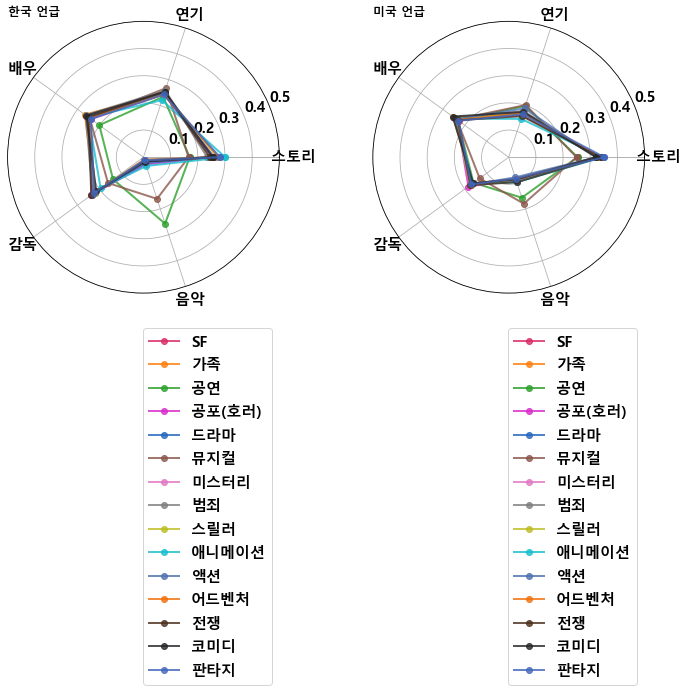

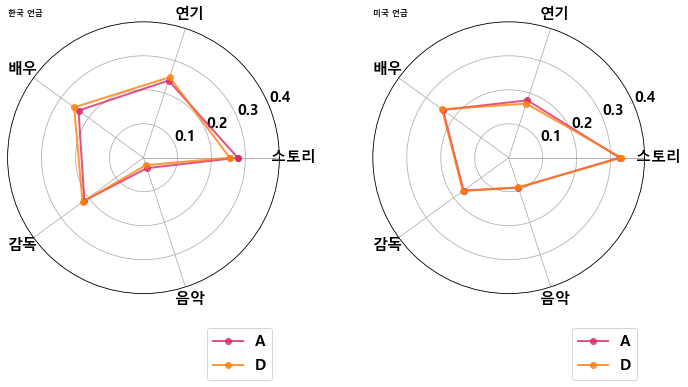

In [33]:
v1 = values
v2 = values_e
comment = "언급"
#---------------------------------------------------------------------------------------------------------------------------------------------------------
v1, v2 = pd.DataFrame(v1, columns= ["v_"+i+'_kr' for i in words], index=indexes), pd.DataFrame(v2, columns=["v_"+i+'_en' for i in words], index=indexes)
df2= df.join(v1)
df2= df2.join(v2)

temp = df2.groupby(['genres']).mean()
temp3 = pd.read_excel("최종데이터.xlsx")
temp3 = temp3[['index', 'kor_audience_class']].set_index("index").join(df2[df2.columns[9:]]).dropna()
temp3 = temp3.groupby(['kor_audience_class']).mean()

#---------------------------------------------------------------------------------------------------------------
"""'SF', '가족', '공연', '공포(호러)', '다큐멘터리', '드라마', '멜로/로맨스', '뮤지컬', '미스터리',
       '범죄', '사극', '서부극(웨스턴)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디',
       '판타지'"""

cat = ['SF', '가족', '공연', '공포(호러)', '드라마',  '뮤지컬', '미스터리',
       '범죄', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디',
       '판타지']

dic = {i:j for i,j in zip(temp.index.values, range(len(temp.index)))}
cat = [dic[i] for i in cat]
make_radar_charts_2([i for j,i in  enumerate(temp.index) if j in cat],
                    [temp.iloc[j,1:len(words)+1].values.tolist() for j, i in  enumerate(temp.index) if j in cat],
                    [i for j,i in  enumerate(temp.index) if j in cat],
                    [temp.iloc[j,len(words)+1:].values.tolist() for j, i in  enumerate(temp.index) if j in cat],
                    left= '한국 '+comment, right='미국 '+comment)


#---------------------------------------------------------------------------------------------------------------
cat = ['A', 'D']

dic = {i:j for i,j in zip(temp3.index.values, range(len(temp3.index)))}
cat = [dic[i] for i in cat]
make_radar_charts_2([i for j,i in  enumerate(temp3.index) if j in cat],
                    [temp3.iloc[j,:len(words)].values.tolist() for j, i in  enumerate(temp3.index) if j in cat],
                    [i for j,i in  enumerate(temp3.index) if j in cat],
                    [temp3.iloc[j,len(words):].values.tolist() for j, i in  enumerate(temp3.index) if j in cat],
                    left= '한국 '+comment, right='미국 '+comment, fonts=8)

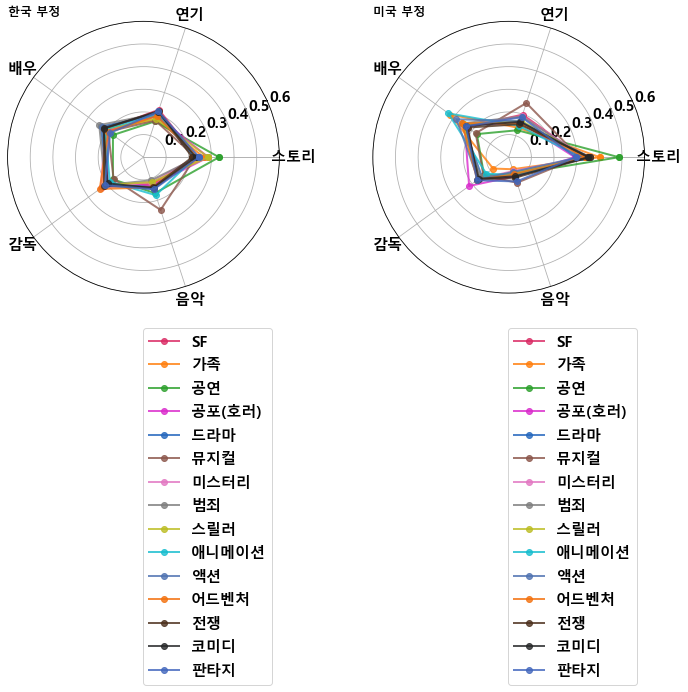

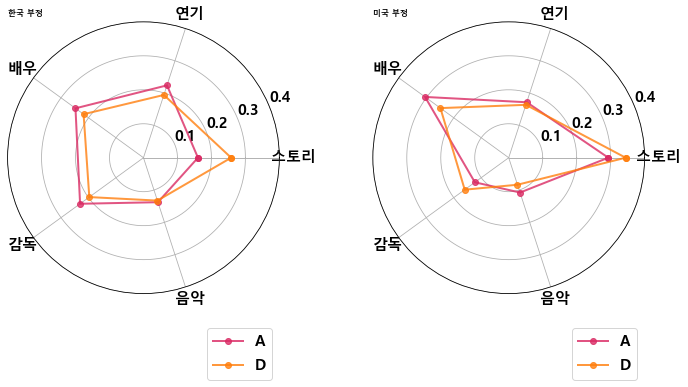

In [34]:
v1 = values_neg
v2 = values_e_neg
comment = "부정"
#---------------------------------------------------------------------------------------------------------------------------------------------------------
v1, v2 = pd.DataFrame(v1, columns= ["v_"+i+'_kr' for i in words], index=indexes), pd.DataFrame(v2, columns=["v_"+i+'_en' for i in words], index=indexes)
df2= df.join(v1)
df2= df2.join(v2)

temp = df2.groupby(['genres']).mean()
temp3 = pd.read_excel("최종데이터.xlsx")
temp3 = temp3[['index', 'kor_audience_class']].set_index("index").join(df2[df2.columns[9:]]).dropna()
temp3 = temp3.groupby(['kor_audience_class']).mean()

#---------------------------------------------------------------------------------------------------------------
"""'SF', '가족', '공연', '공포(호러)', '다큐멘터리', '드라마', '멜로/로맨스', '뮤지컬', '미스터리',
       '범죄', '사극', '서부극(웨스턴)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디',
       '판타지'"""

cat = ['SF', '가족', '공연', '공포(호러)', '드라마',  '뮤지컬', '미스터리',
       '범죄', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디',
       '판타지']

dic = {i:j for i,j in zip(temp.index.values, range(len(temp.index)))}
cat = [dic[i] for i in cat]
make_radar_charts_2([i for j,i in  enumerate(temp.index) if j in cat],
                    [temp.iloc[j,1:len(words)+1].values.tolist() for j, i in  enumerate(temp.index) if j in cat],
                    [i for j,i in  enumerate(temp.index) if j in cat],
                    [temp.iloc[j,len(words)+1:].values.tolist() for j, i in  enumerate(temp.index) if j in cat],
                    left= '한국 '+comment, right='미국 '+comment)


#---------------------------------------------------------------------------------------------------------------
cat = ['A','D']

dic = {i:j for i,j in zip(temp3.index.values, range(len(temp3.index)))}
cat = [dic[i] for i in cat]
make_radar_charts_2([i for j,i in  enumerate(temp3.index) if j in cat],
                    [temp3.iloc[j,:len(words)].values.tolist() for j, i in  enumerate(temp3.index) if j in cat],
                    [i for j,i in  enumerate(temp3.index) if j in cat],
                    [temp3.iloc[j,len(words):].values.tolist() for j, i in  enumerate(temp3.index) if j in cat],
                    left= '한국 '+comment, right='미국 '+comment, fonts=8)

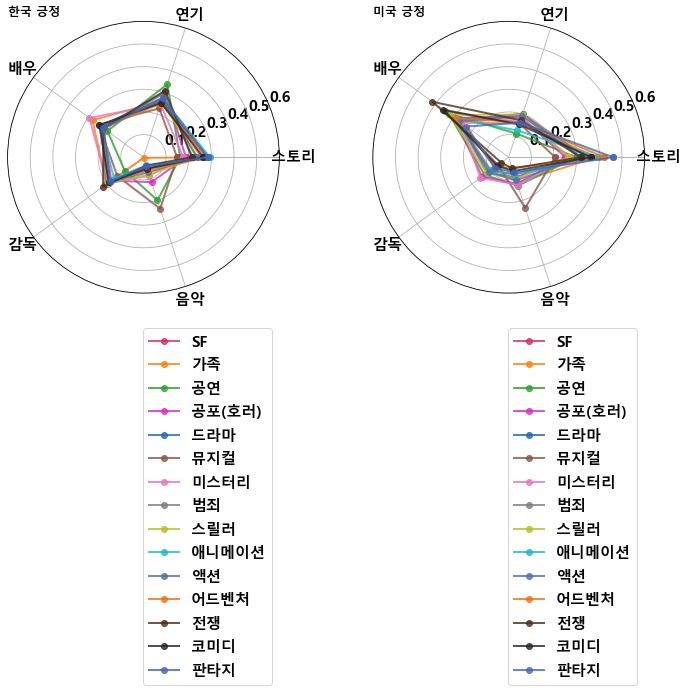

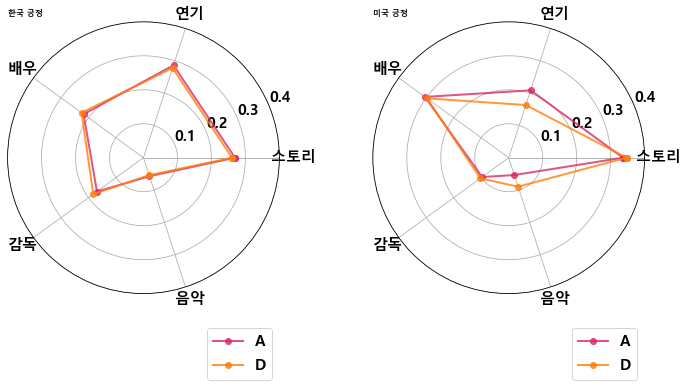

In [35]:
v1 = values_pos
v2 = values_e_pos
comment = "긍정"
#---------------------------------------------------------------------------------------------------------------------------------------------------------
v1, v2 = pd.DataFrame(v1, columns= ["v_"+i+'_kr' for i in words], index=indexes), pd.DataFrame(v2, columns=["v_"+i+'_en' for i in words], index=indexes)
df2= df.join(v1)
df2= df2.join(v2)

temp = df2.groupby(['genres']).mean()
temp3 = pd.read_excel("최종데이터.xlsx")
temp3 = temp3[['index', 'kor_audience_class']].set_index("index").join(df2[df2.columns[9:]]).dropna()
temp3 = temp3.groupby(['kor_audience_class']).mean()

#---------------------------------------------------------------------------------------------------------------
"""'SF', '가족', '공연', '공포(호러)', '다큐멘터리', '드라마', '멜로/로맨스', '뮤지컬', '미스터리',
       '범죄', '사극', '서부극(웨스턴)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디',
       '판타지'"""

cat = ['SF', '가족', '공연', '공포(호러)', '드라마',  '뮤지컬', '미스터리',
       '범죄', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디',
       '판타지']

dic = {i:j for i,j in zip(temp.index.values, range(len(temp.index)))}
cat = [dic[i] for i in cat]
make_radar_charts_2([i for j,i in  enumerate(temp.index) if j in cat],
                    [temp.iloc[j,1:len(words)+1].values.tolist() for j, i in  enumerate(temp.index) if j in cat],
                    [i for j,i in  enumerate(temp.index) if j in cat],
                    [temp.iloc[j,len(words)+1:].values.tolist() for j, i in  enumerate(temp.index) if j in cat],
                    left= '한국 '+comment, right='미국 '+comment)


#---------------------------------------------------------------------------------------------------------------
cat = ['A','D']

dic = {i:j for i,j in zip(temp3.index.values, range(len(temp3.index)))}
cat = [dic[i] for i in cat]
make_radar_charts_2([i for j,i in  enumerate(temp3.index) if j in cat],
                    [temp3.iloc[j,:len(words)].values.tolist() for j, i in  enumerate(temp3.index) if j in cat],
                    [i for j,i in  enumerate(temp3.index) if j in cat],
                    [temp3.iloc[j,len(words):].values.tolist() for j, i in  enumerate(temp3.index) if j in cat],
                    left= '한국 '+comment, right='미국 '+comment, fonts=8)

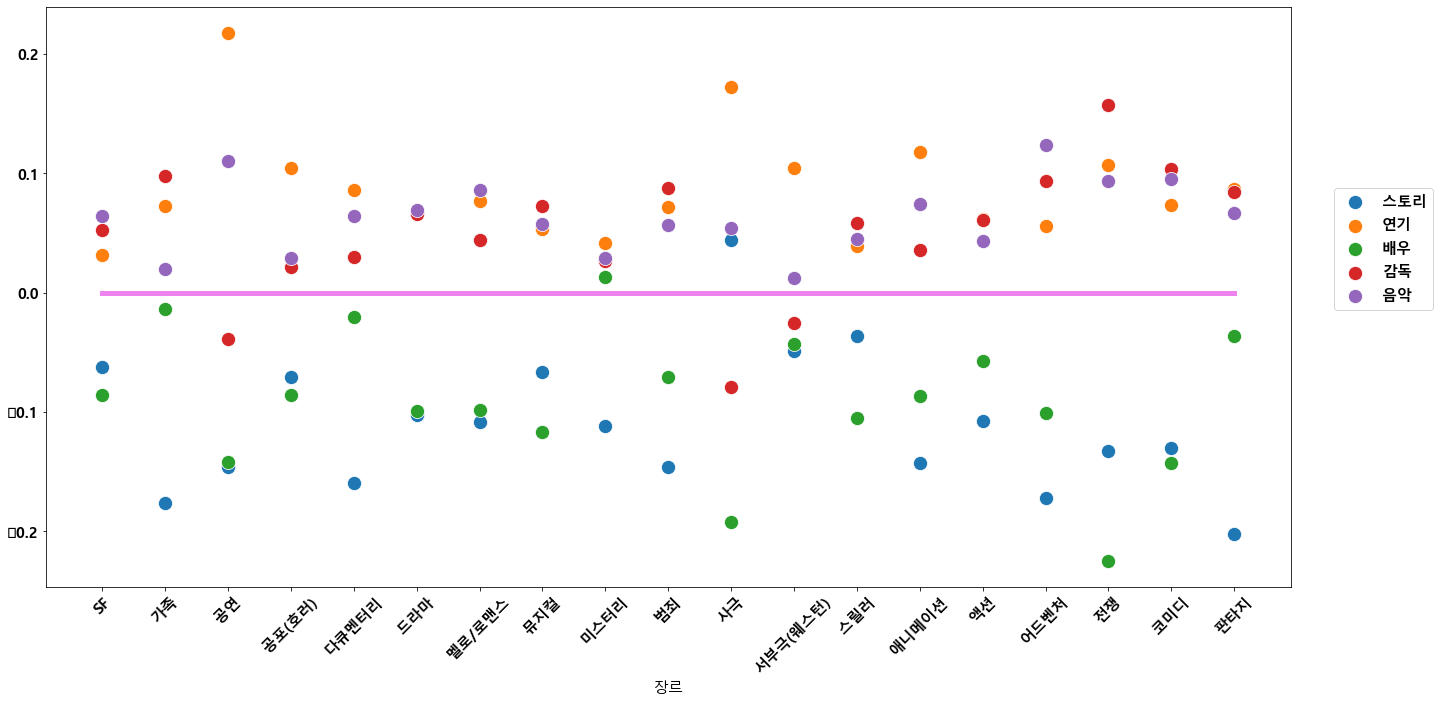

In [158]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


kr, en  = temp.iloc[0,1:1+len(words)].values, temp.iloc[0,1+len(words):].values
for i in range(1,1+len(words)):
    temp['diff_'+str(i)] = temp.iloc[:,i] - temp.iloc[:,i+5]


plt.figure(figsize=(20,10))
for j in range(len(words)):
    sns.scatterplot(temp.index.values, temp[temp.columns[1+len(words)*2+j]], s=200)
_ = plt.xticks(temp.index.values, rotation=45)
#sns.scatterplot(temp.index.values, temp[temp.columns[16]],s=500, marker=11, color='black')
plt.legend(words, bbox_to_anchor=(0,0,1.12,0.7))
_ = sns.lineplot(x=temp.index.values, y=[0 for i in range(len(temp))], lw=5, c='violet',linestyle= (0, (1, 10)))
_ = plt.ylabel("", fontdict={'fontsize':15}).set_rotation(0)
_ = plt.xlabel("장르", fontdict={'fontsize':15})
plt.tight_layout(True)

In [ ]:
temp['diff'].sort_values(ascending=False).to_frame().style.background_gradient(cmap='summer') 

In [40]:
temp3

,v_스토리_kr,v_연기_kr,v_배우_kr,v_감독_kr,v_음악_kr,v_스토리_en,v_연기_en,v_배우_en,v_감독_en,v_음악_en
kor_audience_class,,,,,,,,,,
A,0.201774,0.215726,0.196035,0.191974,0.194492,0.215242,0.215399,0.219842,0.183163,0.166353
B,0.185082,0.224809,0.191520,0.190803,0.207786,0.205457,0.215212,0.212579,0.181605,0.185147
C,0.192948,0.220414,0.199700,0.189620,0.197319,0.207401,0.217040,0.215250,0.180296,0.180012
D,0.197232,0.217034,0.194144,0.191459,0.200132,0.204041,0.219755,0.215471,0.180330,0.180403
F,0.877181,0.211230,0.188596,0.183184,-0.460191,0.196710,0.221468,0.214662,0.180858,0.186302


In [174]:
temp2 = df2[df2.columns[9:]].mean()

In [175]:
temp = df2.groupby(['genres']).mean()
temp3 = pd.read_excel("최종_등급.xlsx")
temp3 = temp3[['index', 'kor_audience_class']].set_index("index").join(df2[df2.columns[9:]]).dropna()
temp3 = temp3.groupby(['kor_audience_class']).count()

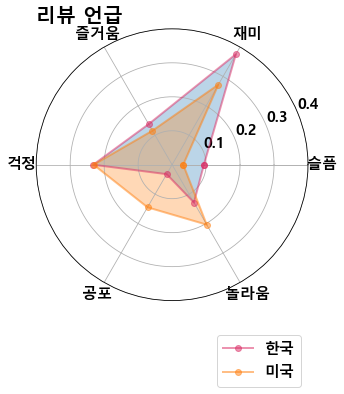

In [178]:
v1 = values
v2 = values_e
comment = "언급"
#---------------------------------------------------------------------------------------------------------------------------------------------------------
v1, v2 = pd.DataFrame(v1, columns= ["v_"+i+'_kr' for i in words], index=indexes), pd.DataFrame(v2, columns=["v_"+i+'_en' for i in words], index=indexes)
df2= df.join(v1)
df2= df2.join(v2)

temp2 = df2[df2.columns[9:]].mean()
make_radar_charts(['한국','미국'], [temp2.values[:len(words)], temp2.values[len(words):]], title="리뷰 "+comment, fonts=20)

In [43]:
temp3

,v_스토리_kr,v_연기_kr,v_배우_kr,v_감독_kr,v_음악_kr,v_스토리_en,v_연기_en,v_배우_en,v_감독_en,v_음악_en
kor_audience_class,,,,,,,,,,
A,29,29,29,29,29,29,29,29,29,29
B,181,181,181,181,181,181,181,181,181,181
C,404,404,404,404,404,404,404,404,404,404
D,606,606,606,606,606,606,606,606,606,606
F,426,426,426,426,426,426,426,426,426,426


In [23]:
import matplotlib
matplotlib.rcParams['font.family']
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

In [25]:
df

,영화명,스토리,평점,리뷰,영화명ENen,리뷰en,평점en,시청등급en,genres
2,드라이브,"줄거리\n차가운 심장의 남자,\n지켜야 할 사람이 생겼다!\n삶의 의미라곤 오직 스...",8.04,매우 폭력 스타일리시 매력 저절로 웃음 기존 액션 영화 예술 미와 아름다 움 라이언...,Drive,One reviewer here suggested that instead of se...,NaN,NaN,액션
8,킬러맨,줄거리\n뉴욕의 돈세탁 업자 ‘모’는 파트너 ‘스컹크’와 함께\n 마약 거래에 뛰어...,5.40,걸 끝 본 사람 나중 대성 할 겁니다 전 실패했거든요 인생 최악 영화 평점 점 보고...,Killerman,Strong performance intimidating villain claust...,"5.4/10\n3,165",18,액션
9,테넷,줄거리\n당신에게 줄 건 한 단어 ‘테넷’\n“이해하지 말고 느껴라!”\n시간의 흐...,8.65,이영화 보고 나올 드는 생각 한번 봐야겠다 추강 추강 요어밌재 말정 도래 만지겠 르...,Tenet,First viewing I couldn t understand the dialog...,"8.4/10\n2,577",12,액션
10,존 윅 - 리로드,줄거리\n장전 완료! 준비는 끝났다!\n업계 최고의 레전드 킬러 ‘존 윅’은 과거를...,8.05,피어스 네오 다시 만나다니 감동 연필 무서움 편 존 윅 부기맨 명 연필 하나로 죽였...,John Wick Chapter Two,Adding to his earlier Wickipedia page with a s...,"7.5/10\n351,231",18,액션
12,O.J. 심슨 사건 파일,"줄거리\n미 전역을 들끓게 한 충격 실화\nO.J. 심슨, 아내 살해 혐의로 체포되...",8.50,실제 살인 범 심슨 임 영화 일반 연쇄 살인 범 니콜 브라운 심슨 살해 묘사 되네요...,The Murder of Nicole Brown Simpson,Completely fictional trash Bad acting Bad dire...,2.1/10\n868,18,스릴러
...,...,...,...,...,...,...,...,...,...
3990,스텝 업 3D,"줄거리\n춤에 미치고, 음악에 흥분하고, 온몸으로 전율하라!\n뉴욕 최고의 댄스팀 ...",9.13,무스 졸멋 졸멋 개 소름 월드 잼 태극기 스텝업 도 개 쩔음 정말 스텝업 시리즈 명...,Step Up 3-D,Step Up D maybe the best D movie since Avatar ...,"6.2/10\n55,087",12,드라마
3991,솔트,줄거리\n그녀는 누구인가?\n러시아 정보원이 그녀를 이중 첩자로 지목하자 에블린 솔...,7.75,속이 뻥뻥 뚫리는 통쾌한 액션 정말 재미있게 봤어용 헐 진짜 재밋 기자 평론가 평점...,Salt,I found this thriller to be enjoyable Lots of ...,"6.4/10\n291,130",15,스릴러
3992,마법사의 제자,줄거리\n뉴욕 맨하탄을 질주하는 최강 마법사들의 격돌\n현대 과학이 집결된 최첨단의...,7.48,전적 빅잼 데이브 플라즈마 코일 원리퍼블릭 시크릿 연주 할 영화 명장 인듯 외 머 ...,The Sorcerer'S Apprentice,The same people who to me are surprisingly rud...,"6.1/10\n150,720",All,드라마
3995,나잇&데이,줄거리\n평범한 커리어 우먼 준(카메론 디아즈)은 우연히 공항에서 꿈에 그리던 이상...,8.37,비싼 장면 기절 처리 재임 내 생각 영화 가장 멋있는 대사 웃기 기도 톰 크루즈 진...,Knight & Day,Great blend of action and comedy I never felt ...,"6.3/10\n177,203",15,액션


In [31]:
df2

,영화명,스토리,평점,리뷰,영화명ENen,리뷰en,평점en,시청등급en,genres,v_스토리_kr,v_연기_kr,v_배우_kr,v_감독_kr,v_음악_kr,v_스토리_en,v_연기_en,v_배우_en,v_감독_en,v_음악_en
2,드라이브,"줄거리\n차가운 심장의 남자,\n지켜야 할 사람이 생겼다!\n삶의 의미라곤 오직 스...",8.04,매우 폭력 스타일리시 매력 저절로 웃음 기존 액션 영화 예술 미와 아름다 움 라이언...,Drive,One reviewer here suggested that instead of se...,NaN,NaN,액션,0.243402,0.219942,0.246335,0.246335,0.043986,0.336836,0.115701,0.280776,0.144657,0.122030
8,킬러맨,줄거리\n뉴욕의 돈세탁 업자 ‘모’는 파트너 ‘스컹크’와 함께\n 마약 거래에 뛰어...,5.40,걸 끝 본 사람 나중 대성 할 겁니다 전 실패했거든요 인생 최악 영화 평점 점 보고...,Killerman,Strong performance intimidating villain claust...,"5.4/10\n3,165",18,액션,0.250013,0.250013,0.250013,0.250013,-0.000050,0.321323,0.184716,0.230771,0.187068,0.076123
9,테넷,줄거리\n당신에게 줄 건 한 단어 ‘테넷’\n“이해하지 말고 느껴라!”\n시간의 흐...,8.65,이영화 보고 나올 드는 생각 한번 봐야겠다 추강 추강 요어밌재 말정 도래 만지겠 르...,Tenet,First viewing I couldn t understand the dialog...,"8.4/10\n2,577",12,액션,0.242166,0.256411,0.243590,0.250713,0.007121,0.327506,0.214768,0.200018,0.161831,0.095877
10,존 윅 - 리로드,줄거리\n장전 완료! 준비는 끝났다!\n업계 최고의 레전드 킬러 ‘존 윅’은 과거를...,8.05,피어스 네오 다시 만나다니 감동 연필 무서움 편 존 윅 부기맨 명 연필 하나로 죽였...,John Wick Chapter Two,Adding to his earlier Wickipedia page with a s...,"7.5/10\n351,231",18,액션,0.243120,0.252295,0.256882,0.247708,-0.000005,0.330355,0.221020,0.202225,0.191641,0.054759
12,O.J. 심슨 사건 파일,"줄거리\n미 전역을 들끓게 한 충격 실화\nO.J. 심슨, 아내 살해 혐의로 체포되...",8.50,실제 살인 범 심슨 임 영화 일반 연쇄 살인 범 니콜 브라운 심슨 살해 묘사 되네요...,The Murder of Nicole Brown Simpson,Completely fictional trash Bad acting Bad dire...,2.1/10\n868,18,스릴러,0.111062,0.333407,0.333407,0.222235,-0.000111,0.335301,0.145497,0.236993,0.210526,0.071683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,스텝 업 3D,"줄거리\n춤에 미치고, 음악에 흥분하고, 온몸으로 전율하라!\n뉴욕 최고의 댄스팀 ...",9.13,무스 졸멋 졸멋 개 소름 월드 잼 태극기 스텝업 도 개 쩔음 정말 스텝업 시리즈 명...,Step Up 3-D,Step Up D maybe the best D movie since Avatar ...,"6.2/10\n55,087",12,드라마,0.452072,0.178081,0.123282,0.164381,0.082184,0.289337,0.142290,0.228259,0.208781,0.131333
3991,솔트,줄거리\n그녀는 누구인가?\n러시아 정보원이 그녀를 이중 첩자로 지목하자 에블린 솔...,7.75,속이 뻥뻥 뚫리는 통쾌한 액션 정말 재미있게 봤어용 헐 진짜 재밋 기자 평론가 평점...,Salt,I found this thriller to be enjoyable Lots of ...,"6.4/10\n291,130",15,스릴러,0.369875,0.191780,0.232879,0.205480,-0.000014,0.313207,0.164653,0.201753,0.196888,0.123499
3992,마법사의 제자,줄거리\n뉴욕 맨하탄을 질주하는 최강 마법사들의 격돌\n현대 과학이 집결된 최첨단의...,7.48,전적 빅잼 데이브 플라즈마 코일 원리퍼블릭 시크릿 연주 할 영화 명장 인듯 외 머 ...,The Sorcerer'S Apprentice,The same people who to me are surprisingly rud...,"6.1/10\n150,720",All,드라마,0.264229,0.211382,0.256099,0.268294,-0.000004,0.342595,0.229515,0.206100,0.162653,0.059137
3995,나잇&데이,줄거리\n평범한 커리어 우먼 준(카메론 디아즈)은 우연히 공항에서 꿈에 그리던 이상...,8.37,비싼 장면 기절 처리 재임 내 생각 영화 가장 멋있는 대사 웃기 기도 톰 크루즈 진...,Knight & Day,Great blend of action and comedy I never felt ...,"6.3/10\n177,203",15,액션,0.312509,0.203125,0.281256,0.203125,-0.000016,0.289435,0.195107,0.245691,0.188754,0.081013


In [33]:
temp3 = pd.read_excel("최종_등급.xlsx")
temp3 = temp3[['index', 'kor_audience_class']].set_index("index").join(df2[df2.columns[9:]]).dropna()

In [56]:
for t in tq.tqdm(indexes):
    review1 = naver.loc[t, '리뷰']
    movie_nm = naver.loc[t,'영화명']
    value = [0.001 for i in range(len(lst))]
    value_pos = [0.001 for i in range(len(lst))]
    value_neg = [0.001 for i in range(len(lst))]
    string_split = str(review1).split()
    for k2, i in enumerate(string_split):
        for k,j in enumerate(lst):
            if i in j:
                value[k] +=1
                left = max([0, k2-1])
                right = k2+2
                score =sum([score_ko(i) for i in string_split[left:right]])
                if score >0:
                    value_pos[k] += score
                if score <0:
                    value_neg[k] += score
    print(value, value_pos, value_neg)
    if int(t)>10:
        break
    


[328.001, 362.001, 399.001, 345.001, 51.001] [118.001, 103.001, 118.001, 82.001, 9.001] [-20.999000000000002, -14.999, -19.999000000000002, -16.999000000000002, -3.999]
[9.001, 8.001, 7.0009999999999994, 8.001, 0.001] [0.001, 0.001, 0.001, 0.001, 0.001] [-1.999, -1.999, -1.999, -1.999, 0.001]
[379.001, 441.001, 407.001, 425.001, 20.000999999999998] [65.001, 94.001, 76.001, 76.001, 2.001] [-53.999, -54.999, -52.999, -50.999, -0.999]
[245.001, 225.001, 227.001, 208.001, 12.001] [56.001, 52.001, 48.001, 34.001, 5.0009999999999994] [-11.999, -17.999000000000002, -19.999000000000002, -14.999, -0.999]
[2.001, 4.0009999999999994, 4.0009999999999994, 4.0009999999999994, 0.001] [0.001, 0.001, 0.001, 0.001, 0.001] [0.001, 0.001, -0.999, 0.001, 0.001]



In [ ]:
SUM = sum(value_pos)
v = [value_pos[i]/SUM for i in range(len(value_pos))]
v

In [ ]:
translator.translate(["별로인 스토리 그냥 다음 배우"])[0].text

In [22]:
import matplotlib
matplotlib.rcParams['font.family']
matplotlib.rcParams['font.family'] = 'Malgun Gothic'